In [32]:
import joblib
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna
import warnings
from denseweight import DenseWeight
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
xgb.set_config(verbosity=1)

In [43]:
models_path = '../models'
# model_dir_path = models_path + '/1m-label_1.0.1/sub-train-BTC_1648771200'
model_dir_path = models_path + '/1m-label_7/sub-train-BTC_1648771200'

def load_data():
    train_X_path = model_dir_path + '/cb_btc_1648771200_trained_df.pkl'
    train_Y_path = model_dir_path + '/cb_btc_1648771200_trained_labels_df.pkl'
    with open(train_X_path, 'rb') as f:
        train_X = pickle.load(f)

    with open(train_Y_path, 'rb') as f:
        train_Y = pickle.load(f)
    
    return train_X, train_Y

def load_model():
    model_path = model_dir_path + '/cb_btc_1648771200_model.joblib'
    return joblib.load(model_path)

train_X, train_Y = load_data()

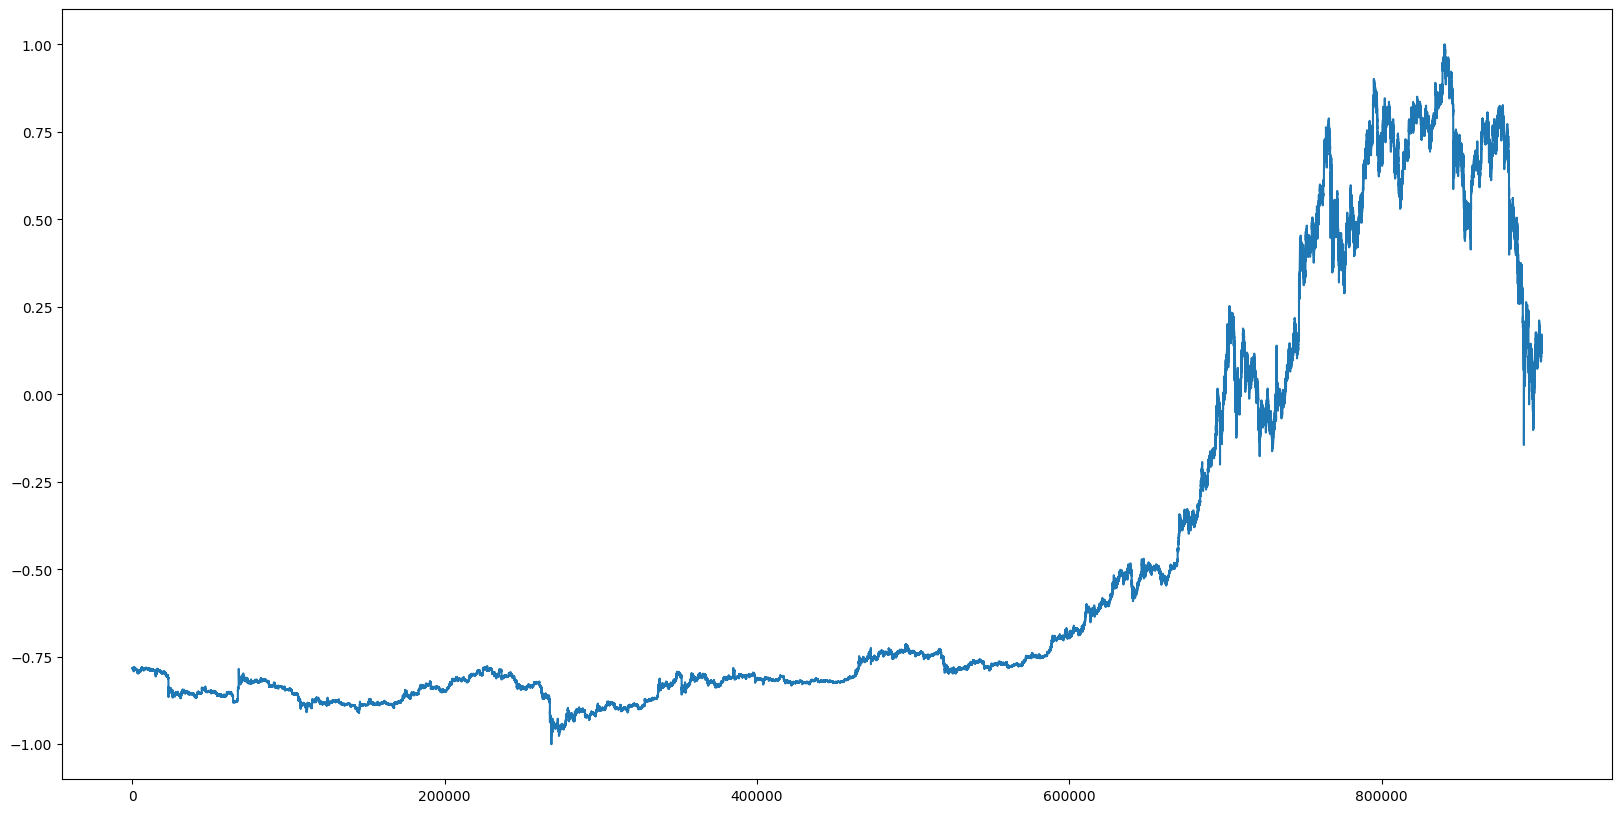

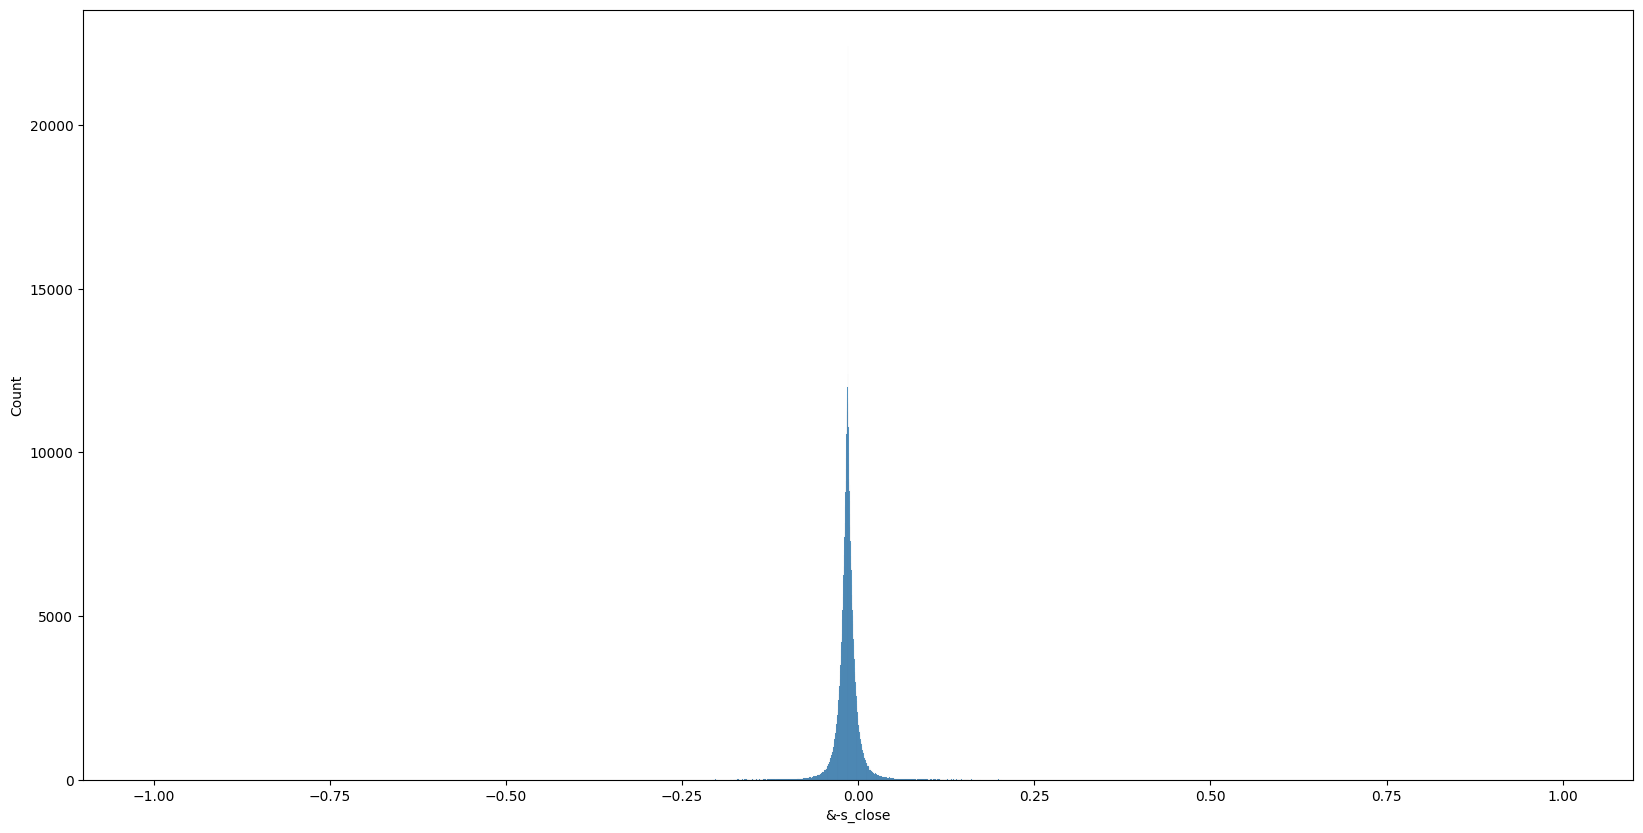

In [44]:
def plot_chart():
    plt.figure(figsize=(20, 10))
    price_column = '%-raw_price_gen_BTC/USDTUSDT_1m'
    plt.plot(train_X[price_column], label='price')
    plt.show()

def plot_label_hist():
    plt.figure(figsize=(20, 10))
    label_column = '&-s_close'
    sns.histplot(train_Y[label_column])
    plt.show()

plot_chart()
plot_label_hist()
    

In [35]:
# filter out columns that have shift
def filter_out_columns(train_X, column):
    columns_to_filterout = train_X.filter(regex=column).columns.tolist()
    columns_wo_shift = train_X.columns[~train_X.columns.isin(columns_to_filterout)].tolist()
    train_X = train_X[columns_wo_shift]
    return train_X

train_X = filter_out_columns(train_X, 'sma')
train_X = filter_out_columns(train_X, 'ema')
train_X = filter_out_columns(train_X, 'raw')
train_X = filter_out_columns(train_X, 'shift')

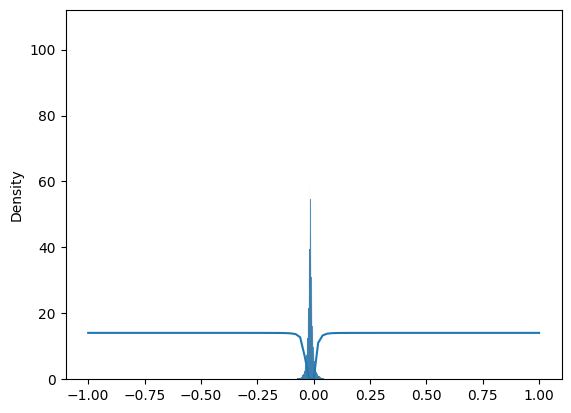

In [58]:
def get_weights(labels, alpha=1):
    dw = DenseWeight(alpha=alpha)
    dw.fit(labels)
    counts, bins = np.histogram(labels, bins=100)
    density = dw.eval(bins)
    sns.histplot(labels,stat='density')
    plt.plot(bins, density)
    return dw.weights

weights = get_weights(train_Y['&-s_close'].values, alpha=10)

In [59]:
X_train, X_test, y_train, y_test, train_weights, test_weights = train_test_split(
    train_X, train_Y, weights, train_size=0.9, test_size=0.1, random_state=1, shuffle=True
)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


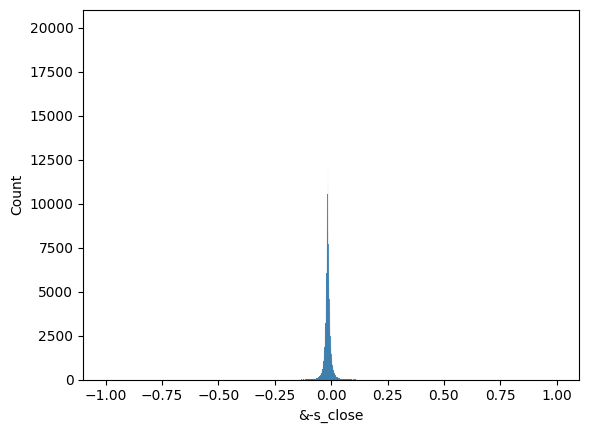

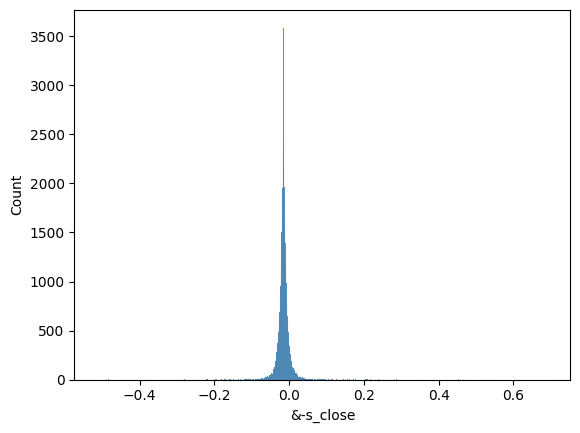

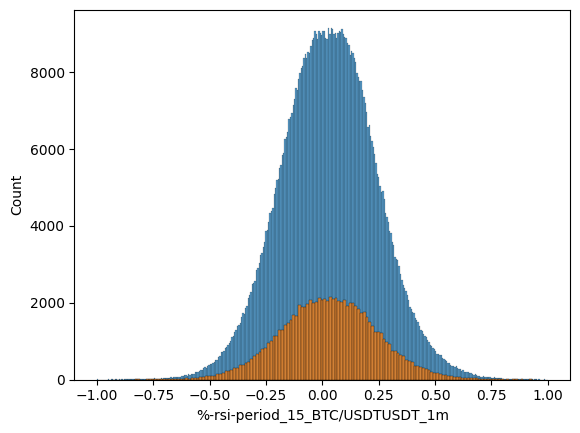

KeyboardInterrupt: 

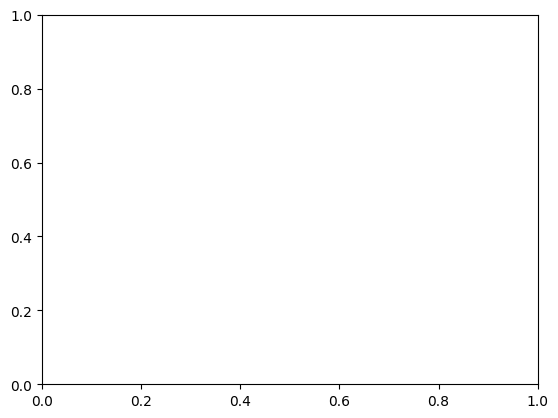

In [ ]:
def plot_datasets():
    sns.histplot(y_train['&-s_close'])
    plt.show()
    sns.histplot(y_test['&-s_close'])
    plt.show()
    for col in train_X.columns:
        sns.histplot(X_train[col])
        sns.histplot(X_test[col])
        plt.show()

plot_datasets()

In [60]:
model = XGBRegressor(
    eval_metric="rmse",
    n_estimators=1000,
    gamma=0.5,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    tree_method="gpu_hist",
    # predictor="gpu_predictor",
)
model.fit(
    X_train,
    y_train,
    early_stopping_rounds=10,
    sample_weight=train_weights,
    # eval_set=[(X_train,y_train)],
    eval_set=[(X_train, y_train), (X_test, y_test)],
    # sample_weight_eval_set=[(train_weights)],
    sample_weight_eval_set=[(train_weights), (test_weights)],
    verbose=True,
)

print("Best RMSE: {:.2f} with {} rounds".format(model.best_score, model.best_iteration + 1))

[0]	validation_0-rmse:0.46662	validation_1-rmse:0.46701
[1]	validation_0-rmse:0.42056	validation_1-rmse:0.42108
[2]	validation_0-rmse:0.37915	validation_1-rmse:0.37976
[3]	validation_0-rmse:0.34194	validation_1-rmse:0.34270
[4]	validation_0-rmse:0.30854	validation_1-rmse:0.30940
[5]	validation_0-rmse:0.27855	validation_1-rmse:0.27953
[6]	validation_0-rmse:0.25163	validation_1-rmse:0.25278
[7]	validation_0-rmse:0.22750	validation_1-rmse:0.22882
[8]	validation_0-rmse:0.20586	validation_1-rmse:0.20740
[9]	validation_0-rmse:0.18650	validation_1-rmse:0.18826
[10]	validation_0-rmse:0.16921	validation_1-rmse:0.17119
[11]	validation_0-rmse:0.15378	validation_1-rmse:0.15601
[12]	validation_0-rmse:0.13999	validation_1-rmse:0.14252
[13]	validation_0-rmse:0.12770	validation_1-rmse:0.13057
[14]	validation_0-rmse:0.11682	validation_1-rmse:0.12005
[15]	validation_0-rmse:0.10718	validation_1-rmse:0.11080
[16]	validation_0-rmse:0.09866	validation_1-rmse:0.10261
[17]	validation_0-rmse:0.09110	validation

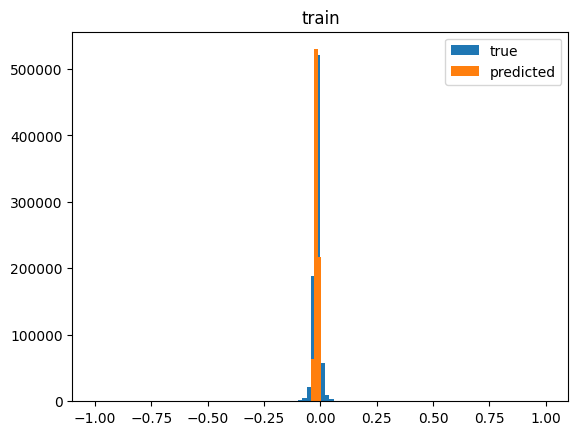

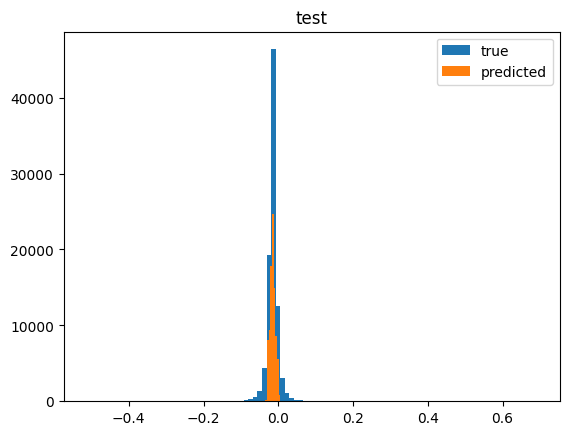

RMSE on train: 0.02, test: 0.02


In [63]:
def calc_rmse():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    print("RMSE on train: {:.2f}, test: {:.2f}".format(rmse_train, rmse_test))

def plot_prediction_hists():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    plt.title('train')
    # sns.histplot(y_train)
    # sns.histplot(y_pred_train)
    plt.hist(y_train, bins=100)
    plt.hist(y_pred_train, bins=100)
    plt.legend(['true', 'predicted'])
    plt.show()

    plt.title('test')
    # sns.histplot(y_test)
    # sns.histplot(y_pred_test)
    plt.hist(y_test, bins=100)
    plt.hist(y_pred_test, bins=100)
    plt.legend(['true', 'predicted'])
    plt.show()

plot_prediction_hists()
calc_rmse()


In [53]:
def objective(trial):
    """Define the objective function"""

    params = {
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "subsample": trial.suggest_loguniform("subsample", 0.01, 1.0),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.01, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 1.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 1.0),
        "eval_metric": "rmse",
        "n_jobs": -1,
        "tree_method": "gpu_hist",
    }

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-rmse")

    # Fit the model
    optuna_model = XGBRegressor(**params)
    optuna_model.fit(
        X_train,
        y_train,
        early_stopping_rounds=10,
        sample_weight=train_weights,
        eval_set=[(X_test, y_test)],
        sample_weight_eval_set=[(test_weights)],
        verbose=False,
        callbacks=[pruning_callback],
    )

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    mse = mean_squared_error(y_test, y_pred, squared=False, sample_weight=test_weights)
    return mse


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2023-05-08 18:09:11,609] A new study created in memory with name: no-name-50bab8e9-23ea-4e72-a45e-93fddad9f14a
[I 2023-05-08 18:09:33,343] Trial 0 finished with value: 0.05601909330192773 and parameters: {'max_depth': 14, 'learning_rate': 0.03328166665117245, 'n_estimators': 883, 'min_child_weight': 19, 'gamma': 8.377374940241358e-07, 'subsample': 0.035851065802822824, 'colsample_bytree': 0.05630905245152907, 'reg_alpha': 0.009447332201383407, 'reg_lambda': 4.979858577046859e-05}. Best is trial 0 with value: 0.05601909330192773.
[I 2023-05-08 18:10:02,343] Trial 1 finished with value: 0.05628303670443934 and parameters: {'max_depth': 20, 'learning_rate': 0.024814558283130065, 'n_estimators': 577, 'min_child_weight': 2, 'gamma': 1.9791320169097493e-08, 'subsample': 0.0862191951669769, 'colsample_bytree': 0.2439762680719386, 'reg_alpha': 0.04075779291973301, 'reg_lambda': 1.486318152115528e-07}. Best is trial 0 with value: 0.05601909330192773.
[I 2023-05-08 18:10:17,026] Trial 2 finis

: 

: 

In [ ]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

In [ ]:
model = XGBRegressor(**trial.params)
model.fit(
    X_train,
    y_train,
    early_stopping_rounds=10,
    sample_weight=train_weights,
    eval_set=[(X_test, y_test)],
    sample_weight_eval_set=[(test_weights)],
    verbose=True,
)
